## Imports

In [1]:
import os
import sys
import numpy as np
import random
import skimage.io as io
from struct import pack, unpack
from io import StringIO, BytesIO
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data

## Defining MIDI constants

In [2]:
NOTE_MIDI_OFF = 0x80
NOTE_MIDI_ON = 0x90
A_TOUCH = 0xA0
CONT_CONTROL = 0xB0 
PATCH_CHG_MIDI = 0xC0
CHNL_PRESS = 0xD0
MIDI_PITCH_BND = 0xE0                                                                                  
SYS_EXCL_MIDI = 0xF0
MTC_MIDI = 0xF1
SNG_POS_MIDI_POINTER = 0xF2
SNG_SEL_MIDI = 0xF3
TUNE_REQ_MIDI = 0xF6
END_OFF_EXCL_MIDI = 0xF7 
SEQ_NUM = 0x00  
MIDI_TXT            = 0x01  
MIDI_CR       = 0x02  
SEQ_NAME_MIDI   = 0x03  
INSTR_NAME_MIDI = 0x04  
MIDI_LRC           = 0x05  
MIDI_MRKR          = 0x06  
CUEPNT_MIDI        = 0x07  
PROG_NAME_MIDI    = 0x08  
DVC_NAME     = 0x09  
CH_PREF  = 0x20  
PRT       = 0x21  
E_O_T    = 0x2F  
TMP           = 0x51  
SMTP_MIDI_OFF     = 0x54  
TIME_SIGN_MIDI  = 0x58  
KEY_SIGN_MIDI   = 0x59  
MIDI_SPEC        = 0x7F  
MIDI_TRK_HEAD    = 'MTrk'
MIDI_MET_EVNT     = 0xFF

## MIDI handling code

In [3]:
class MOStrm:
    def __init__(self):
        self._abs_t = 0
        self._rel_t = 0
        self._cur_trk = 0
        self._run_stat = None
    def time_update(self, t_new=0, rel_flag=1):
        if rel_flag:
            self._rel_t = t_new
            self._abs_t += t_new
        else:
            self._rel_t = t_new - self._abs_t
            self._abs_t = t_new
    def t_reset(self):
        self._rel_t = 0
        self._abs_t = 0        
    def t_rel(self):
        return self._rel_t
    def t_abs(self):
        return self._abs_t    
    def set_cur_trk(self, trk_new):
        self._cur_trk = trk_new
    def midi_nt_on(self, chnl=0, nt=0x40, vel=0x40):
        pass
    def midi_nt_off(self, chnl=0, nt=0x40, vel=0x40):
        pass
    def aft_tch(self, chnl=0, nt=0x40, vel=0x40):
        pass
    def cont_ctrl(self, chnl, crtler, v):
        pass
    def pch_chg(self, chnl, pch):
        pass
    def chnl_press(self, chnl, press):
        pass
    def pch_bnd(self, chnl, v):
        pass
    def sng_pos_ptr(self, v):
        pass
    def sng_sel(self, sng_num):
        pass
    def tun_req(self):
        pass        
    def t_cod(self, typ_m, vals):
        pass
    def hdr(self, fmt=0, num_trs=1, divs=96):
        pass
    def end_of_file(self):
        pass
    def mt_evt(self, mt_typ, d):
        pass
    def s_o_trk(self, num_trk=0):
        pass
    def e_o_trk(self):
        pass
    def seq_num(self, v):
        pass
    def txt(self, txt):
        pass
    def cr(self, txt):
        pass
    def seq_nam(self, txt):
        pass
    def inst_nam(self, txt):
        pass
    def lrc(self, txt):
        pass
    def mrkr(self, txt):
        pass
    def cuepnt(self, txt):
        pass
    def ch_prf(self, chnl):
        pass
    def m_prt(self, v):
        pass
    def tmp(self, v):
        pass
    def smtp_midi_off(self, hr, mn, sec, fm, fmprt):
        pass
    def t_sign_midi(self, n, d, c, b):
        pass
    def k_sign_midi(self, s, m):
        pass
    def seq_spc(self, d):
        pass

In [4]:
class MIFl:
    def __init__(self, ostr, ifl):
        self.r_input = RIStrFl(ifl)
        self.prs = MFlPrsr(self.r_input, ostr)
    def op_rd(self):
        prs = self.prs
        prs.pMdChk()
        prs.pMTChks()
    def d_set(self, d=''):
        self.r_input.d_set(d)

In [5]:
class MOFl(MOStrm):
    def __init__(self, r_output=''):
        self.r_output = ROStrFl(r_output)
        MOStrm.__init__(self)    
    def op_wrt(self):
        self.r_output.op_wrt()
    def midi_evt_slc(self, e_slice):
        curr_track = self._cur_trk_bfr
        curr_track.op_wrt_var_len(self.t_rel())
        curr_track.op_wrt_slc(e_slice)
    def midi_nt_on(self, chnl=0, nt=0x40, vel=0x40):
        curr_slice = strm_to_data([NOTE_MIDI_ON + chnl, nt, vel])
        self.midi_evt_slc(curr_slice)
    def midi_nt_off(self, chnl=0, nt=0x40, vel=0x40):
        curr_slice = strm_to_data([NOTE_MIDI_OFF + chnl, nt, vel])
        self.midi_evt_slc(curr_slice)
    def aft_tch(self, chnl=0, nt=0x40, vel=0x40):
        curr_slice = strm_to_data([A_TOUCH + chnl, nt, vel])
        self.midi_evt_slc(curr_slice)
    def cont_ctrl(self, chnl, ctrler, v):
        curr_slice = strm_to_data([CONT_CONTROL + chnl, ctrler, v])
        self.midi_evt_slc(curr_slice)
    def pch_chg(self, chnl, pch):
        curr_slice = strm_to_data([PATCH_CHG_MIDI + chnl, pch])
        self.midi_evt_slc(curr_slice)
    def chnl_press(self, chnl, press):
        curr_slice = strm_to_data([CHNL_PRESS + chnl, press])
        self.midi_evt_slc(curr_slice)
    def pch_bnd(self, chnl, v):
        m = (v>>7) & 0xFF
        l = v & 0xFF
        curr_slice = strm_to_data([MIDI_PITCH_BND + chnl, m, l])
        self.midi_evt_slc(curr_slice)
    def t_cod(self, typ_m, vals):
        v = (typ_m<<4) + vals
        self.midi_evt_slc(strm_to_data([MIDI_TIME_CODE, v]))
    def sng_pos_ptr(self, v):
        l = (v & 0x7F)
        m = (v >> 7) & 0x7F
        self.midi_evt_slc(strm_to_data([SNG_POS_MIDI_POINTER, l, m]))
    def sng_sel(self, sng_num):
        self.midi_evt_slc(strm_to_data([SNG_SEL_MIDI, sng_num]))
    def tun_req(self):
        self.midi_evt_slc(chr(TUNE_REQ_MIDI))
    def hdr(self, fmt=0, num_trs=1, divs=96):       
        r_data = self.r_output
        r_data.op_wrt_slc('MThd')
        b = r_data.op_bew_wrt
        b(6, 4)
        b(fmt, 2)
        b(num_trs, 2)
        b(divs, 2)
    def end_of_file(self):
        self.op_wrt()
    def m_slc(self, mt_typ, data_slice):
        slc = strm_to_data([MIDI_MET_EVNT, mt_typ]) + \
                         op_wrt_var(len(data_slice)) +  data_slice
        self.midi_evt_slc(slc)
    def mt_evt(self, mt_typ, d):
        self.m_slc(mt_typ, strm_to_data(d))
    def s_o_trk(self, num_trk=0):
        self._cur_trk_bfr = ROStrFl()
        self.t_reset()
        self._cur_trk += 1
    def e_o_trk(self):
        r_output = self.r_output
        r_output.op_wrt_slc(MIDI_TRK_HEAD)
        d_trk = self._cur_trk_bfr.fetch_val()
        e_o_t_slc = op_wrt_var(self.t_rel()) + strm_to_data([MIDI_MET_EVNT, E_O_T, 0])
        r_output.op_bew_wrt(len(d_trk)+len(e_o_t_slc), 4)
        r_output.op_wrt_slc(d_trk)
        r_output.op_wrt_slc(e_o_t_slc)
    def seq_num(self, v):
        self.m_slc(mt_typ, op_bew_wrt(v, 2))
    def midi_txt(self, txt):
        self.m_slc(MIDI_TXT, txt)
    def cr(self, txt):
        self.m_slc(MIDI_CR, txt)
    def seq_nam(self, txt):
        self.m_slc(SEQ_NAME_MIDI, txt)
    def inst_nam(self, txt):
        self.m_slc(INSTR_NAME_MIDI, txt)
    def lrc(self, txt):
        self.m_slc(MIDI_LRC, txt)
    def mrkr(self, txt):
        self.m_slc(MIDI_MRKR, txt)
    def cuepnt(self, txt):
        self.m_slc(CUEPNT_MIDI, txt)
    def ch_prf(self, chnl):
        self.m_slc(CH_PREF, chr(chnl))
    def m_prt(self, v):
        self.m_slc(CH_PREF, chr(v))
    def tmp(self, v):
        h, m, l = (v>>16 & 0xff), (v>>8 & 0xff), (v & 0xff)
        self.m_slc(TMP, strm_to_data([h, m, l]))
    def smtp_midi_off(self, hr, mn, sec, fm, fmprt):
        self.m_slc(SMTP_MIDI_OFF, strm_to_data([hr, mn, sec, fm, fmprt]))
    def t_sign_midi(self, n, d, c, b):
        self.m_slc(TIME_SIGN_MIDI, strm_to_data([n, d, c, b]))
    def k_sign_midi(self, s, m):
        self.m_slc(KEY_SIGN_MIDI, strm_to_data([s, m]))
    def seq_spc(self, d):
        self.m_slc(SEQ_SPC, d)

In [6]:
class RIStrFl:    
    def __init__(self, ifl=''):
        if ifl:
            if isinstance(ifl, str):
                ifl = open(ifl, 'rb')
                self.d = ifl.read()
                ifl.close()
            else:
                self.d = ifl.op_rd()
        else:
            self.d = ''
        self.csr = 0
    def d_set(self, d=''):
        self.d = d
    def get_csr(self):
        return self.csr
    def mv_csr(self, rl_ps=0):
        self.csr += rl_ps
    def nxt_slc(self, ln, mv_csr=1):
        c = self.csr
        slc = self.d[int(c):int(c+ln)]
        if mv_csr:
            self.mv_csr(ln)
        return slc
    def b_read(self, num_bts=1, mv_csr=1):
        return b_read(self.nxt_slc(num_bts, mv_csr))
    def op_rd_var_len(self):
        MX_VLN = 4
        v = op_rd_var(self.nxt_slc(MX_VLN, 0))
        self.mv_csr(get_len_var(v))
        return v

In [7]:
class ROStrFl:
    def __init__(self, ofl=''):
        self.bfr = BytesIO()
        self.ofl = ofl
    def op_wrt_slc(self, s_slc):
        if isinstance(s_slc, str):
            self.bfr.write(s_slc.encode())
        else:
            self.bfr.write(s_slc)
    def op_bew_wrt(self, v, ln=1):
        self.op_wrt_slc(op_bew_wrt(v, ln))
    def op_wrt_var_len(self, v):
        var = self.op_wrt_slc(op_wrt_var(v))
    def op_wrt(self):
        if self.ofl:
            if isinstance(self.ofl, str):
                ofl = open(self.ofl, 'wb')
                ofl.write(self.fetch_val())
                ofl.close()
            else:
                self.ofl.op_wrt(self.fetch_val())
        else:
            sys.stdout.op_wrt(self.fetch_val())                
    def fetch_val(self):
        return self.bfr.getvalue()

In [8]:
class MFlPrsr:
    def __init__(self, r_input, ostr):
        self.r_input = r_input
        self.dpch = EvtDspch(ostr)
        self._run_stat = None
    def pMdChk(self):
        r_input = self.r_input
        hd_chk_typ = r_input.nxt_slc(4)
        hd_chk_sz = r_input.b_read(4)
        if hd_chk_typ != b'MThd':
            raise TypeError("Invalid file type - non MIDI !")
        self.fmt = r_input.b_read(2)
        self.num_tr = r_input.b_read(2)
        self.divs = r_input.b_read(2)
        if hd_chk_sz > 6:
            r_input.mv_csr(hd_chk_sz-6)
        self.dpch.hdr(self.fmt, self.num_tr, self.divs)
    def pMTChk(self):
        self.dpch.t_reset()        
        dpch = self.dpch
        r_input = self.r_input
        dpch.s_o_trk(self._cur_trk)
        r_input.mv_csr(4)
        tr_len = r_input.b_read(4)
        tr_end = r_input.get_csr() + tr_len
        while r_input.get_csr() < tr_end:
            t = r_input.op_rd_var_len()
            dpch.time_update(t)
            pk_fwd = r_input.b_read(mv_csr=0)
            if (pk_fwd & 0x80): 
                st = self._run_stat = r_input.b_read()
            else:
                st = self._run_stat
            h_n, l_n = st & 0xF0, st & 0x0F
            if st == MIDI_MET_EVNT:
                mt_typ = r_input.b_read()
                mt_ln = r_input.op_rd_var_len()
                mt_d = r_input.nxt_slc(mt_ln)
                dpch.mt_evt(mt_typ, mt_d)
            elif st == SYS_EXCL_MIDI:
                ssx_ln = r_input.op_rd_var_len()
                ssx_d = r_input.nxt_slc(ssx_ln-1)
                if r_input.b_read(mv_csr=0) == END_OFF_EXCL_MIDI:
                    e_o_ssx = r_input.b_read()
                dpch.ssx_ev(ssx_d)
            elif h_n == 0xF0:
                d_sz = {
                    MTC_MIDI:1,
                    SNG_POS_MIDI_POINTER:2,
                    SNG_SEL_MIDI:1,
                }
                d_s = d_sz.get(h_n, 0)
                cmn_d = r_input.nxt_slc(d_s)
                cmn_t = l_n
                dpch.sys_cmn(cmn_t, cmn_d)
            else:
                d_sz = {
                    PATCH_CHG_MIDI:1,
                    CHNL_PRESS:1,
                    NOTE_MIDI_OFF:2,
                    NOTE_MIDI_ON:2,
                    A_TOUCH:2,
                    CONT_CONTROL:2,
                    MIDI_PITCH_BND:2,
                }
                d_s = d_sz.get(h_n, 0)
                ch_d = r_input.nxt_slc(d_s)
                ev_ty, chnl = h_n, l_n
                dpch.chnl_msg(ev_ty, chnl, ch_d)
    def pMTChks(self):
        for t in range(self.num_tr):
            self._cur_trk = t
            self.pMTChk()
        self.dpch.end_of_file()

In [9]:
class EvtDspch:
    def __init__(self, ostr):
        self.ostr = ostr
        self.conv_vel_zero = 1
        self.cont_ctrl_dpch = 1
        self.dpch = 1
    def hdr(self, fmt, num_trs, divs):
        self.ostr.hdr(fmt, num_trs, divs)
    def s_o_trk(self, cur_trk):
        self.ostr.set_cur_trk(cur_trk)
        self.ostr.s_o_trk(cur_trk)
    def ssx_ev(self, d):
        self.ostr.ssx_ev(d)
    def end_of_file(self):
        self.ostr.end_of_file()
    def time_update(self, t_new=0, rel_flag=1):
        self.ostr.time_update(t_new, rel_flag)
    def t_reset(self):
        self.ostr.t_reset()
    def chnl_msg(self, h_n, chnl, d):
        strm = self.ostr
        d = data_to_strm(d)
        if (NOTE_MIDI_ON & 0xF0) == h_n:
            nt, vel = d
            if vel==0 and self.conv_vel_zero:
                strm.midi_nt_off(chnl, nt, 0x40)
            else:
                strm.midi_nt_on(chnl, nt, vel)        
        elif (NOTE_MIDI_OFF & 0xF0) == h_n:
            nt, vel = d
            strm.midi_nt_off(chnl, nt, vel)        
        elif (A_TOUCH & 0xF0) == h_n:
            nt, vel = d
            strm.aft_tch(chnl, nt, vel)        
        elif (CONT_CONTROL & 0xF0) == h_n:
            ctrlr, v = d
            if self.cont_ctrl_dpch:
                self.cnt_ctrls(chnl, ctrlr, v)
            else:
                strm.cont_ctrl(chnl, ctrlr, v)
        elif (PATCH_CHG_MIDI & 0xF0) == h_n:
            prg = d[0]
            strm.pch_chg(chnl, prg)    
        elif (CHNL_PRESS & 0xF0) == h_n:
            press = d[0]
#             strm.ch_press(chnl, press)            
        elif (MIDI_PITCH_BND & 0xF0) == h_n:
            hb, lb = d
            v = (hb<<7) + lb
            strm.pch_bnd(chnl, v)
        else:
            raise ValueError('Channel message error - illegal message !')            
    def cnt_ctrls(self, chnl, ctrlr, v):
        strm = self.ostr
        strm.cont_ctrl(chnl, ctrlr, v)
    def mt_evt(self, mt_typ, d):
        strm = self.ostr
        if mt_typ == SEQ_NUM:
            n = b_read(d)
            strm.seq_num(n)
        elif mt_typ == MIDI_TXT:
            strm.txt(d)
        elif mt_typ == MIDI_CR:
            strm.cr(d)
        elif mt_typ == SEQ_NAME_MIDI:
            strm.seq_nam(d)
        elif mt_typ == INSTR_NAME_MIDI:
            strm.inst_nam(d)
        elif mt_typ == MIDI_LRC:
            strm.lrc(d)
        elif mt_typ == MIDI_MRKR:
            strm.mrkr(d)
        elif mt_typ == CUEPNT_MIDI:
            strm.cuepnt(d)
        elif mt_typ == DVC_NAME:
            strm.dvc_nam(d)
        elif mt_typ == CH_PREF:
            chnl = b_read(d)
            strm.ch_prf(chnl)
        elif mt_typ == PRT:
            port = b_read(d)
            strm.m_prt(port)
        elif mt_typ == E_O_T:
            strm.e_o_trk()
        elif mt_typ == TMP:
            b1, b2, b3 = data_to_strm(d)
            strm.tmp((b1<<16) + (b2<<8) + b3)
        elif mt_typ == SMTP_MIDI_OFF:
            hr, mn, sec, fm, fmprt = data_to_strm(d)
            strm.smtp_midi_off(
                    hr, mn, sec, fm, fmprt)
        elif mt_typ == TIME_SIGN_MIDI:
            n, d, c, b = data_to_strm(d)
            strm.t_sign_midi(n, d, c, b)
        elif mt_typ == KEY_SIGN_MIDI:
            sf, mi = data_to_strm(d)
            strm.k_sign_midi(sf, mi)
        elif mt_typ == MIDI_SPEC:
            mt_d = data_to_strm(d)
            strm.seq_spc(mt_d)
        else:
            mt_d = data_to_strm(d)
            strm.meta_event(mt_typ, mt_d)

In [10]:
def b_read(v):
    return unpack('>%s' % {1:'B', 2:'H', 4:'L'}[len(v)], v)[0]
def op_bew_wrt(v, l):
    return pack('>%s' % {1:'B', 2:'H', 4:'L'}[l], v)
def op_rd_var(v):
    count = 0
    for b in unpack('%sB' % len(v), v):
        count = (count << 7) + (b & 0x7F)
        if not 0x80 & b: 
            break
    return count
def get_len_var(v):
    if v <= 127:
        return 1
    elif v <= 16383:
        return 2
    elif v <= 2097151:
        return 3
    else:
        return 4
def op_wrt_var(v):
    s = data_to_bits(v, get_len_var(v))
    for i in range(len(s)-1):
        s[i] = s[i] | 0x80
    return strm_to_data(s)
def data_to_bits(v, l=1, nbs=7):
    b = [(v >> (j*nbs)) & 0x7F for j in range(l)]
    b.reverse()
    return b
def data_to_strm(v):
    return unpack('%sB' % len(v), v)
def strm_to_data(v):
    if not v: return ''
    return pack('%sB' % len(v), *v)

In [11]:
class MidiDataRead(MOStrm):
  def __init__(self, fname, rng=(21, 109), dtm=0.2):
    self.nts = []
    self._tmp = 500000
    self.bt = 0
    self.t = 0.0
    m_in = MIFl(self, fname)
    m_in.op_rd()
    self.nts = [n for n in self.nts if n[2] is not None]  
    ln = int(np.ceil(max(list(zip(*self.nts))[2]) / dtm))  
    self.pio_rl = np.zeros((ln, rng[1]-rng[0]))
    for n in self.nts:
      self.pio_rl[int(np.ceil(n[1]/dtm)) : int(np.ceil(n[2]/dtm)), n[0]-rng[0]] = 1
  def t_in_sec(self):
    return self.t + self._tmp * (self.t_abs() - self.bt) * 1e-6 / self.div
  def tmp(self, v):
    self.t = self.t_in_sec()
    self.bt = self.t_abs()
    self._tmp = v  
  def hdr(self, fmt=0, num_tr=1, divs=96):
    self.div = divs
  def midi_nt_on(self, chnl=0, nt=0x40, vel=0x40):
    self.nts.append([nt, self.t_in_sec(), None])
  def midi_nt_off(self, chnl=0, nt=0x40, vel=0x40):
    i = len(self.nts) - 1
    while i >= 0 and self.nts[i][0] != nt:
      i -= 1
    if i >= 0 and self.nts[i][2] is None:
      self.nts[i][2] = self.t_in_sec()
  def ssx_ev(*args):
    pass
  def dvc_nam(*args):
    pass
def midiwrite(fname, pio_rl, rng=(21, 109), dtm=0.2, patch=0):
  md = MOFl(fname)
  md.hdr(divs=100)
  md.s_o_trk() 
  md.pch_chg(chnl=0, pch=patch)
  tm = 0
  smp = [i.nonzero()[0] + rng[0] for i in pio_rl]
  for i in range(len(smp)):
    for f in smp[i]:
      if i==0 or f not in smp[i-1]:
        md.time_update(tm)
        md.midi_nt_on(chnl=0, nt=f, vel=90)
        tm = 0
    tm += int(dtm*200)
    for f in smp[i]:
      if i==len(smp)-1 or f not in smp[i+1]:
        md.time_update(tm)
        md.midi_nt_off(chnl=0, nt=f, vel=0)
        tm = 0
  md.time_update(0)
  md.e_o_trk()
  md.end_of_file()

# PyTorch CODE STARTS HERE !

## DataLoader

In [12]:
def md_fl_to_pio_rl(md_fl):    
    md_d = MidiDataRead(md_fl, dtm=0.3)
    pio_rl = md_d.pio_rl.transpose()
    pio_rl[pio_rl > 0] = 1    
    return pio_rl
def pd_pio_rl(pio_rl, mx_l=132333, pd_v=0):        
    orig_rol_len = pio_rl.shape[1]    
    pdd_rol = np.zeros((88, mx_l))
    pdd_rol[:] = pd_v    
    pdd_rol[:, - orig_rol_len:] = pio_rl
    return pdd_rol
class NtGenDataset(data.Dataset):    
    def __init__(self, md_pth, mx_seq_ln=1491):        
        self.md_pth = md_pth        
        md_fnames = os.listdir(md_pth)        
        self.mx_seq_ln = mx_seq_ln        
        md_fnames_ful = map(lambda fname: os.path.join(md_pth, fname),md_fnames)        
        self.md_fnames_ful = list(md_fnames_ful)        
        if mx_seq_ln is None:            
            self.mx_len_upd()    
    def mx_len_upd(self):        
        seq_lens = map(lambda fname: md_fl_to_pio_rl(fname).shape[1],self.md_fnames_ful)        
        mx_l = max(seq_lens)
        self.mx_seq_ln = mx_l    
    def __len__(self):        
        return len(self.md_fnames_ful)    
    def __getitem__(self, index):        
        md_fname_ful = self.md_fnames_ful[index]        
        pio_rl = md_fl_to_pio_rl(md_fname_ful)
        seq_len = pio_rl.shape[1] - 1
        ip_seq = pio_rl[:, :-1]
        gt_seq = pio_rl[:, 1:]
        ip_seq_pad = pd_pio_rl(ip_seq, mx_l=self.mx_seq_ln)
        gt_seq_pad = pd_pio_rl(gt_seq,mx_l=self.mx_seq_ln,pd_v=-100)       
        ip_seq_pad = ip_seq_pad.transpose()
        gt_seq_pad = gt_seq_pad.transpose()
        return (torch.FloatTensor(ip_seq_pad),
                torch.LongTensor(gt_seq_pad), torch.LongTensor([seq_len]))
def pos_proc_seq(btch):
    ip_seqs, op_seqs, lens = btch    
    ip_seq_splt_btch = ip_seqs.split(split_size=1)
    op_seq_splt_btch = op_seqs.split(split_size=1)
    btch_splt_lens = lens.split(split_size=1)
    tr_data_tups = zip(ip_seq_splt_btch,
                               op_seq_splt_btch,
                               btch_splt_lens)
    ord_tr_data_tups = sorted(tr_data_tups,
                                         key=lambda c: int(c[2]),
                                         reverse=True)
    ip_seq_splt_btch, op_seq_splt_btch, btch_splt_lens = zip(*ord_tr_data_tups)
    ord_ip_seq_btch = torch.cat(ip_seq_splt_btch)
    ord_op_seq_btch = torch.cat(op_seq_splt_btch)
    ord_btch_lens = torch.cat(btch_splt_lens)    
    ord_ip_seq_btch = ord_ip_seq_btch[:, -ord_btch_lens[0, 0]:, :]
    ord_op_seq_btch = ord_op_seq_btch[:, -ord_btch_lens[0, 0]:, :]    
    tps_ip_seq_btch = ord_ip_seq_btch.transpose(0, 1)    
    ord_btch_lens_l = list(ord_btch_lens)
    ord_btch_lens_l = map(lambda k: int(k), ord_btch_lens_l)    
    return tps_ip_seq_btch, ord_op_seq_btch, list(ord_btch_lens_l)

In [13]:
training_dataset = NtGenDataset('./mozart/train', mx_seq_ln=None)
training_datasetloader = data.DataLoader(training_dataset, batch_size=5,shuffle=True, drop_last=True)

In [14]:
X_train = next(iter(training_datasetloader))
X_train[0].shape

torch.Size([5, 4812, 88])

In [15]:
validation_dataset = NtGenDataset('./mozart/valid/', mx_seq_ln=None)
validation_datasetloader = data.DataLoader(validation_dataset, batch_size=3, shuffle=False, drop_last=False)

In [16]:
X_validation = next(iter(validation_datasetloader))
X_validation[0].shape

torch.Size([3, 1587, 88])

# Music LSTM

### model definition

In [17]:
class MusicLSTM(nn.Module):    
    def __init__(self, ip_sz, hd_sz, n_cls, lyrs=2):        
        super(MusicLSTM, self).__init__()        
        self.ip_sz = ip_sz
        self.hd_sz = hd_sz
        self.n_cls = n_cls
        self.lyrs = lyrs        
        self.nts_enc = nn.Linear(in_features=ip_sz, out_features=hd_sz)        
        self.bn_layer = nn.BatchNorm1d(hd_sz)        
        self.lstm_layer = nn.LSTM(hd_sz, hd_sz, lyrs)        
        self.fc_layer = nn.Linear(hd_sz, n_cls)
        
    def forward(self, ip_seqs, ip_seqs_len, hd=None):
        nts_enc = self.nts_enc(ip_seqs)       
        nts_enc_rol = nts_enc.permute(1,2,0).contiguous()
        nts_enc_nrm = self.bn_layer(nts_enc_rol)        
        nts_enc_nrm_drp = nn.Dropout(0.25)(nts_enc_nrm)
        nts_enc_ful = nts_enc_nrm_drp.permute(2,0,1)
        
        pkd = torch.nn.utils.rnn.pack_padded_sequence(nts_enc_ful, ip_seqs_len)
        op, hd = self.lstm_layer(pkd, hd)
        
        op, op_l = torch.nn.utils.rnn.pad_packed_sequence(op)
        
        op_nrm = self.bn_layer(op.permute(1,2,0).contiguous())
        op_nrm_drp = nn.Dropout(0.1)(op_nrm)
        lgts = self.fc_layer(op_nrm_drp.permute(2,0,1))
        lgts = lgts.transpose(0, 1).contiguous()
        
        rev_lgts = (1 - lgts)
        
        zero_one_lgts = torch.stack((lgts, rev_lgts), dim=3).contiguous()
        flt_lgts = zero_one_lgts.view(-1, 2)
        return flt_lgts, hd

### training and validation

In [18]:
def lstm_model_training(lstm_model, lr, ep=10, val_loss_best=float("inf")):
    list_of_losses = []
    list_of_val_losses =[]
    model_params = lstm_model.parameters()
    opt = torch.optim.Adam(model_params, lr=lr)
    grad_clip = 1.0
    for curr_ep in range(ep):
        lstm_model.train()
        loss_ep = []
        for batch in training_datasetloader:
            post_proc_b = pos_proc_seq(batch)
            ip_seq_b, op_seq_b, seq_l = post_proc_b
            op_seq_b_v =  Variable(op_seq_b.contiguous().view(-1).cpu())
            ip_seq_b_v = Variable(ip_seq_b.cpu())
            opt.zero_grad()
            lgts, _ = lstm_model(ip_seq_b_v, seq_l)
            loss = loss_func(lgts, op_seq_b_v)
            list_of_losses.append(loss.item())
            loss_ep.append(loss.item())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(lstm_model.parameters(), grad_clip)
            opt.step()

        tr_ep_cur = sum(loss_ep)/len(training_datasetloader)
        print(f'ep {curr_ep} , train loss = {tr_ep_cur}')

        vl_ep_cur = evaluate_model(lstm_model)
        print(f'ep {curr_ep} , val loss = {vl_ep_cur}\n')

        list_of_val_losses.append(vl_ep_cur)

        if vl_ep_cur < val_loss_best:
            torch.save(lstm_model.state_dict(), 'best_model.pth')
            val_loss_best = vl_ep_cur
    return val_loss_best, lstm_model

In [19]:
def evaluate_model(lstm_model):
    lstm_model.eval()
    vl_loss_full = 0.0
    seq_len = 0.0

    for batch in validation_datasetloader:
        post_proc_b = pos_proc_seq(batch)
        ip_seq_b, op_seq_b, seq_l = post_proc_b
        op_seq_b_v =  Variable( op_seq_b.contiguous().view(-1).cpu() )
        ip_seq_b_v = Variable( ip_seq_b.cpu() )
        lgts, _ = lstm_model(ip_seq_b_v, seq_l)
        loss = loss_func(lgts, op_seq_b_v)
        vl_loss_full += loss.item()
        seq_len += sum(seq_l)

    return vl_loss_full/(seq_len*88)

In [20]:
loss_func = nn.CrossEntropyLoss().cpu()
lstm_model = MusicLSTM(ip_sz=88, hd_sz=512, n_cls=88).cpu()
val_loss_best, lstm_model = lstm_model_training(lstm_model, lr=0.01, ep=10)

ep 0 , train loss = 1.2445591886838276
ep 0 , val loss = 1.3352128363692468e-06

ep 1 , train loss = 2.1156165103117623
ep 1 , val loss = 1.6539533744088603e-06

ep 2 , train loss = 1.6429476936658223
ep 2 , val loss = 6.44313576921296e-07

ep 3 , train loss = 1.3036367297172546
ep 3 , val loss = 7.910344729101428e-07

ep 4 , train loss = 0.6105860968430837
ep 4 , val loss = 1.2166870756004527e-06

ep 5 , train loss = 0.582861324151357
ep 5 , val loss = 5.687958283017817e-07

ep 6 , train loss = 0.28131235639254254
ep 6 , val loss = 4.83049781240143e-07

ep 7 , train loss = 0.1561812162399292
ep 7 , val loss = 5.472248898085979e-07

ep 8 , train loss = 0.14845856527487436
ep 8 , val loss = 4.1753687837465244e-07

ep 9 , train loss = 0.1285532539089521
ep 9 , val loss = 3.899009367655375e-07



# Generate samples

In [21]:
def generate_music(lstm_model, ln=100, tmp=1, seq_st=None):
    if seq_st is None:
        seq_ip_cur = torch.zeros(1, 1, 88)
        seq_ip_cur[0, 0, 40] = 1
        seq_ip_cur[0, 0, 50] = 0
        seq_ip_cur[0, 0, 56] = 0
        seq_ip_cur = Variable(seq_ip_cur.cpu())
    else:
        seq_ip_cur = seq_st
        
    op_seq = [seq_ip_cur.data.squeeze(1)]
    hd = None

    for i in range(ln):
        op, hd = lstm_model(seq_ip_cur, [1], hd)
        probs = nn.functional.softmax(op.div(tmp), dim=1)
        seq_ip_cur = torch.multinomial(probs.data, 1).squeeze().unsqueeze(0).unsqueeze(1)
        seq_ip_cur = Variable(seq_ip_cur.float())
        op_seq.append(seq_ip_cur.data.squeeze(1))

    gen_seq = torch.cat(op_seq, dim=0).cpu().numpy()
    
    return gen_seq

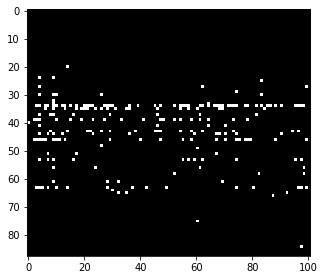

In [22]:
seq = generate_music(lstm_model, ln=100, tmp=0.8, seq_st=None).transpose()
io.imshow(seq)
midiwrite('generated_music.mid', seq.transpose(), dtm=0.25)